In [7]:
#IGNORE THIS 
# print(len(engagement_data_raw[(engagement_data_raw['pct_access'].isna())]))

# print(len(engagement_data_raw[(engagement_data_raw['lp_id'].notna())]))

# print(len(engagement_data_raw[(engagement_data_raw['pct_access'].notna()) & (engagement_data_raw['lp_id'].notna())]))

# print(len(engagement_data_raw[(engagement_data_raw['pct_access'].notna()) & (engagement_data_raw['lp_id'].notna()) & (engagement_data_raw['engagement_index'].notna())]))

In [8]:
# returns a series of boolean values that represent which engagement_index rows are/aren't empty
# engagement_data_raw['engagement_index'].notna()

# returns a boolean series that represents which rows are 'true' for both: engagement_data and lp_id
# using '&' lets you do boolean operations on objects that don't have an explicit boolean value - like a boolean series
# (engagement_data_raw['engagement_index'].notna()) & (engagement_data_raw['lp_id'].notna())

# returns all the rows where the engagement_data and lp_id values are both true
# engagement_data_raw[(engagement_data_raw['engagement_index'].notna()) & (engagement_data_raw['lp_id'].notna())]

# counts the number of rows where engagement_data and lp_id values are both true
# print(len(engagement_data_raw[(engagement_data_raw['engagement_index'].notna()) & (engagement_data_raw['lp_id'].notna())]))

# explanation for how this line works is above
# engagement_data_of_interest = engagement_data_all_raw[(engagement_data_all_raw['engagement_index'].notna()) & (engagement_data_all_raw['lp_id'].notna())]


<h3> Load the required packages </h3>

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests

In [52]:
folder_path = "./Math1130Project-main/Math1130Project-main/engagement_data"

# get a list of all files in the folder
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]

# concatenate all CSV files into a single DataFrame
engagement_data_all_raw = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)


In [50]:
product_info_raw = pd.read_csv("./Math1130Project-main/Math1130Project-main/products_info.csv")

engagement_data_all_raw = pd.DataFrame()

files = os.listdir("./Math1130Project-main/Math1130Project-main/engagement_data")

for csv in files:
    engagement_data_all_raw = engagement_data_all_raw.append(pd.read_csv("./Math1130Project-main/Math1130Project-main/engagement_data/" + csv), ignore_index=True)

engagement_data_all_raw.head()

# engagement_data_list = []
# # pd.DataFrame()

# engagement_data_files = os.listdir("./Math1130Project-main/Math1130Project-main/engagement_data/")

# for csv in engagement_data_files:
#     engagement_data_list.append(pd.read_csv("./Math1130Project-main/Math1130Project-main/engagement_data/" + csv))#, ignore_index=True)

# engagement_data_all_raw_2 = pd.concat(engagement_data_list, ignore_index=True)

# engagement_data_all_raw_2.head()

KeyboardInterrupt: 

From looking at the code below, we can see that roughly XX% of rows don't have either a valid lp_id or valid engagement_data. Those 2 pieces of data are crucial for the analysis - since we need them to know how well a certain platform did.

In [53]:
engagement_data_of_interest = engagement_data_all_raw[(engagement_data_all_raw['engagement_index'].notna()) & (engagement_data_all_raw['lp_id'].notna())]

print(engagement_data_of_interest)

print("Number of non-null rows of interest: " + str(len(engagement_data_of_interest)))

print("Percentage of non-null rows of interest: " + str(round(len(engagement_data_of_interest) / len(engagement_data_all_raw) * 100, 2)) + "%")

del engagement_data_all_raw

                time    lp_id  pct_access  engagement_index
1         2020-01-01  17941.0        0.03              0.90
2         2020-01-01  65358.0        0.03              1.20
3         2020-01-01  98265.0        0.57             37.79
5         2020-01-01  90153.0        0.06              3.90
7         2020-01-01  29322.0        0.06              5.10
...              ...      ...         ...               ...
22324183  2020-12-31  57371.0        0.04              3.94
22324185  2020-12-31  56028.0        0.02              0.20
22324186  2020-12-31  14124.0        0.02              0.99
22324188  2020-12-31  13496.0        0.12              6.51
22324189  2020-12-31  65797.0        0.08             16.56

[16945301 rows x 4 columns]
Number of non-null rows of interest: 16945301
Percentage of non-null rows of interest: 75.91%


Since I'll still have about XX% of valid data left, I'll be able to filter out the null rows, since they won't provide me with any information anyways (I won't know which platform the numbers refer to). 

Additionally, I'll convert the lp_id to a whole number (an int) since those are references to Learning Platform ID's which are also int's.

I'll drop the pct_access column. I believe the pct_access column can skew our view of a platform, because although it does tell us the percentage of students that go on the platform in a day (which can be used to infer the 'popularity' of the platform in a district), it does not represent the quality of the student's learning or their experience using the platform. Quite simply, a student can go on the platform to appease their parents, their teacher, or simply because it's required by the school, but then get bored shortly afterwards and learn nothing. The pct_access would record the student going onto the site, which would increase the pct_access value, thus implying that the platform is popular, which then implies that the platform is good/effective, yet it wouldn't record the student's lack of engagement (which is what we're trying to measure), which would be recorded in the engagement_index. This is why I won't be using the pct_access column.

In [54]:
engagement_data_cleaned = engagement_data_of_interest.copy()

#drop any rows that don't state the learning platform or how engaged students were on that day
engagement_data_cleaned.dropna(subset = ['lp_id', 'engagement_index'])

#convert lp_id column to int
engagement_data_cleaned['lp_id'] = engagement_data_cleaned['lp_id'].astype(int)

engagement_data_cleaned.drop(columns = ['pct_access'], inplace=True)

print(engagement_data_cleaned.head())
print(len(engagement_data_cleaned))
print(len(engagement_data_cleaned['lp_id'].unique()))

         time  lp_id  engagement_index
1  2020-01-01  17941              0.90
2  2020-01-01  65358              1.20
3  2020-01-01  98265             37.79
5  2020-01-01  90153              3.90
7  2020-01-01  29322              5.10
16945301
8292


The time column appears normal, with every date being within 2020, and the format being yyyy-mm-dd. The learning platform id seems normal too.

In [55]:
print(engagement_data_cleaned['time'].value_counts())
print('---------')
print(engagement_data_cleaned['lp_id'].unique())

2020-12-10    83289
2020-12-08    82590
2020-12-09    81510
2020-12-11    80776
2020-12-03    80604
              ...  
2020-07-26    15127
2020-01-04    14540
2020-07-05    14424
2020-07-04    14150
2020-01-01    12538
Name: time, Length: 366, dtype: int64
---------
[17941 65358 98265 ... 63113 38604 43864]


Finding the average student engagement over the course of a year for each learning platform

In [56]:
engagement_data_grouped = engagement_data_cleaned[['lp_id', 'engagement_index']].groupby(['lp_id']).mean('engagement_index').reset_index()

engagement_data_grouped['engagement_index'] = pd.Series.round(engagement_data_grouped['engagement_index'], 3)

engagement_data_grouped.head()

del engagement_data_of_interest

Now, I'll add identifying information to each lp_id, so we can put a platform name to each lp_id. Unfortunately, the product info file doesn't have identifying information about all of the learning platforms (only 372 of them), so I'll need to drop all of the rows with unidentified lp_id's. Because we won't know which learning platform a specific row represents, we won't be able to learn anything about it or draw conclusions from it. 

In [57]:
print(len(product_info_raw['LP ID'].unique()))
print(len(engagement_data_grouped['lp_id'].unique()))
product_engagement_data = engagement_data_grouped.merge(product_info_raw[['LP ID', 'Product Name', 'Sector(s)', 'Primary Essential Function']], 
                                                        how = 'left', left_on='lp_id', right_on='LP ID').drop('LP ID', axis = 1)
print(product_engagement_data.head())

372
8292
   lp_id  engagement_index Product Name Sector(s) Primary Essential Function
0  10003             0.089          NaN       NaN                        NaN
1  10006             0.992          NaN       NaN                        NaN
2  10024             0.080          NaN       NaN                        NaN
3  10032             0.472          NaN       NaN                        NaN
4  10035             0.214          NaN       NaN                        NaN


In [58]:
product_engagement_data.dropna(subset = ["Product Name"], inplace=True)

print(product_engagement_data.head())

     lp_id  engagement_index         Product Name  \
43   10533            76.635           Scholastic   
58   10650             7.738  Library of Congress   
77   10745             7.936         Wonderopolis   
99   11069             9.453             Mr. Donn   
115  11206             2.944         Google Earth   

                         Sector(s)  \
43                         PreK-12   
58   PreK-12; Higher Ed; Corporate   
77                         PreK-12   
99                         PreK-12   
115  PreK-12; Higher Ed; Corporate   

                            Primary Essential Function  
43   LC - Sites, Resources & References - Learning ...  
58                   LC - Sites, Resources & Reference  
77                              LC - Study Tools - Q&A  
99                   LC - Sites, Resources & Reference  
115                  LC - Sites, Resources & Reference  


<h3>Analysing which learning platforms have the highest engagement</h3>

As a baseline, we'd like to consider that any engagement index under 1,000 is considered poor. The reason why is because the engagement_index is averaged over 1,000 people, so an index less than 1,000 means that not all of the students were motivated to even access the platform, and from the ones that did, they likely didn't go past more than 1 page (otherwise, the value would be more than 1,000).

Below, we can see that majority of learning platforms have very low engagement, since 75% of platforms have far less than 1,000 page loads per 1,000 people. 

In [59]:
print(product_engagement_data['engagement_index'].describe())

count      369.000000
mean       137.840927
std        670.382538
min          0.319000
25%          4.913000
50%         17.628000
75%         77.754000
max      10289.882000
Name: engagement_index, dtype: float64


A visual representation of average student engagement for most platforms

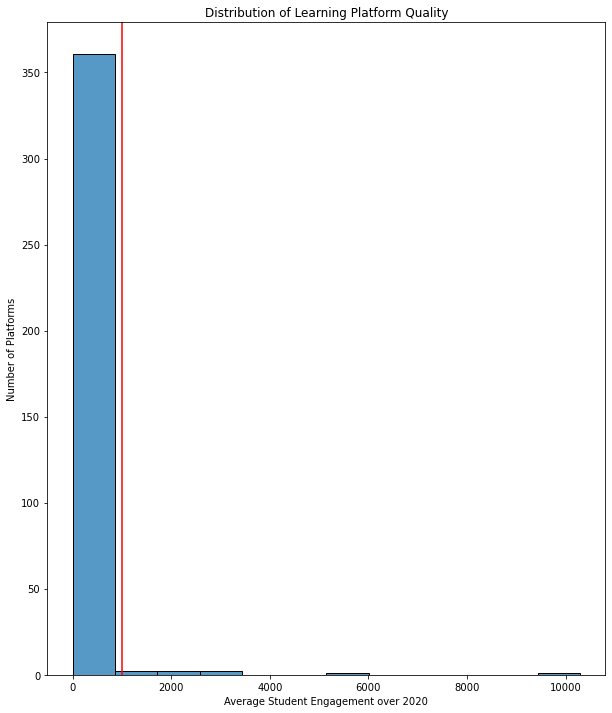

In [90]:
plt.figure(figsize=(10, 12))

bins = 12
sns.histplot(product_engagement_data['engagement_index'], bins = bins)

plt.axvline(x = 1000, color = 'red')

plt.title('Distribution of Learning Platform Quality')
plt.xlabel('Average Student Engagement over 2020')
plt.ylabel('Number of Platforms')

plt.show()

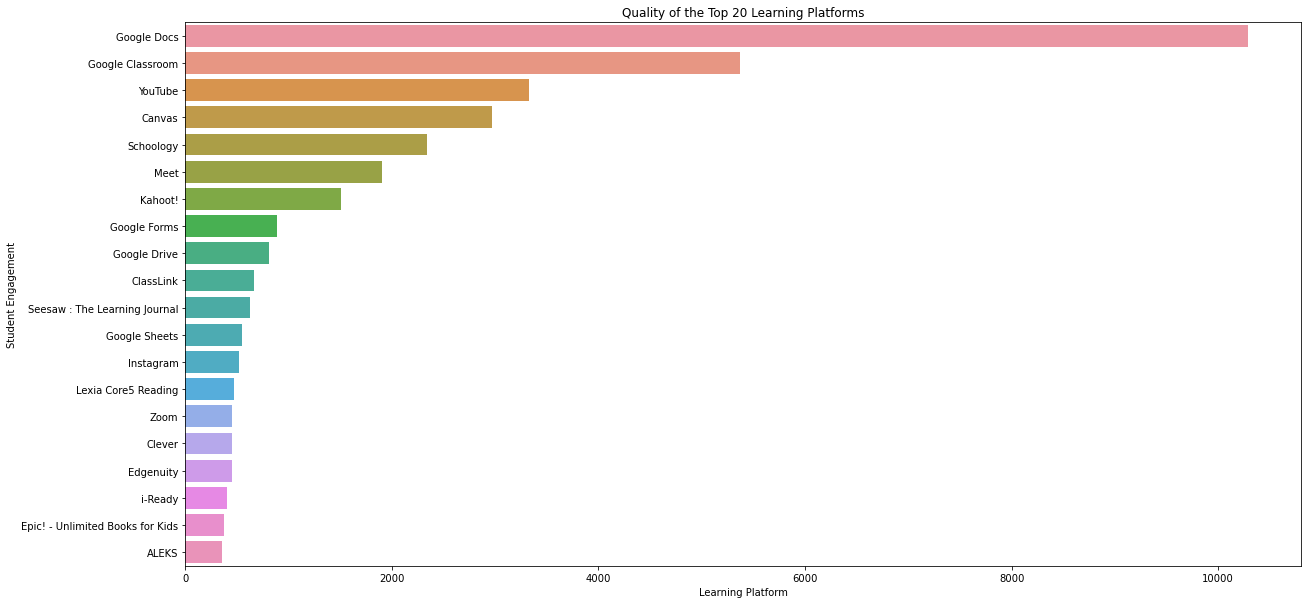

In [61]:
plt.figure(figsize=(20, 10))

sns.barplot(y = 'Product Name', x = 'engagement_index', hue = None, orient = 'h',
    data = product_engagement_data.sort_values(by = 'engagement_index', ascending = False).head(20))

# plt.xticks(rotation = 45)

plt.title('Quality of the Top 20 Learning Platforms')
plt.xlabel('Learning Platform')
plt.ylabel('Student Engagement')

plt.show()

The same plot as above but with a benchmark of 1,000 engagement index or higher 

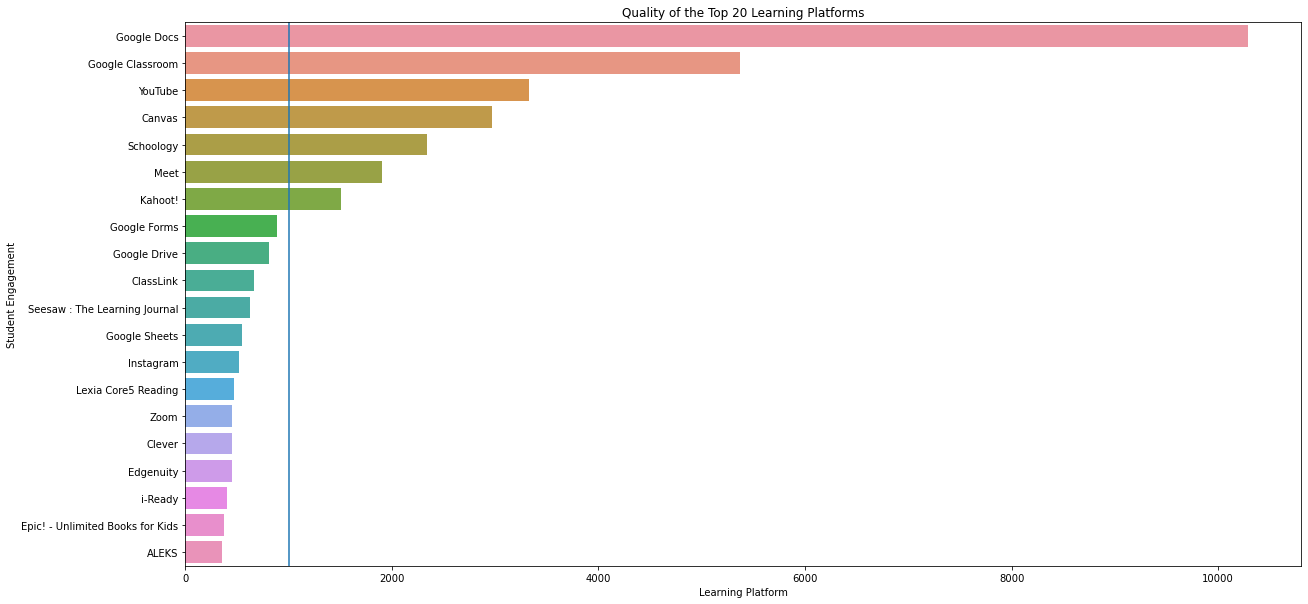

In [62]:
plt.figure(figsize=(20, 10))

sns.barplot(y = 'Product Name', x = 'engagement_index', hue = None, orient = 'h',
    data = product_engagement_data.sort_values(by = 'engagement_index', ascending = False).head(20))

# plt.xticks(rotation = 45)
plt.axvline(x = 1000)

plt.title('Quality of the Top 20 Learning Platforms')
plt.xlabel('Learning Platform')
plt.ylabel('Student Engagement')

plt.show()

<h3>Analysing the most common/popular 'Primary Essential Function' amongst the best learning platforms</h3>

From looking at the code below, we can tell that many of the platforms have primary essential functions that aren't relevant to K-12 education, i.e. CM - Virtual Classroom - Video Conferencing & Screen Sharing, SDO - Admissions, Enrollment & Rostering, SDO - Environmental, Health & Safety (EHS) Compliance, or CM - Teacher Resources - Grading & Attendance. This makes sense since CM is Classroom Management & SDO is School & District Operations. 

LC is the one we care for the most, since it represents all platforms whose primary essential function is related to 'Learning & Curriculum'. As a result, we'll filter out platforms with that area of essential function, and analyse the best platforms within that area.

In [63]:
product_engagement_data["Primary Essential Function"].unique()

array(['LC - Sites, Resources & References - Learning Materials & Supplies',
       'LC - Sites, Resources & Reference', 'LC - Study Tools - Q&A',
       'LC - Sites, Resources & Reference - Games & Simulations',
       'LC - Study Tools - Tutoring', 'LC - Digital Learning Platforms',
       'LC - Sites, Resources & Reference - Digital Collection & Repository',
       'LC - Sites, Resources & Reference - Encyclopedia',
       'SDO - Data, Analytics & Reporting',
       'CM - Classroom Engagement & Instruction - Classroom Management',
       'LC/CM/SDO - Other',
       'LC - Sites, Resources & Reference - Thesaurus & Dictionary',
       'LC - Content Creation & Curation', 'LC - Study Tools',
       'LC - Study Tools - Test Prep & Study Skills',
       'CM - Virtual Classroom - Video Conferencing & Screen Sharing',
       'SDO - Admissions, Enrollment & Rostering',
       'SDO - Learning Management Systems (LMS)',
       'CM - Classroom Engagement & Instruction - Communication & Messagin

In [64]:
primary_essential_func = product_engagement_data[product_engagement_data["Primary Essential Function"].notna()]

primary_essential_func = primary_essential_func[primary_essential_func["Primary Essential Function"].str.startswith("LC - ")]

primary_essential_func.head(10)

,lp_id,engagement_index,Product Name,Sector(s),Primary Essential Function
43,10533,76.635,Scholastic,PreK-12,"LC - Sites, Resources & References - Learning ..."
58,10650,7.738,Library of Congress,PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference"
77,10745,7.936,Wonderopolis,PreK-12,LC - Study Tools - Q&A
99,11069,9.453,Mr. Donn,PreK-12,"LC - Sites, Resources & Reference"
115,11206,2.944,Google Earth,PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference"
119,11237,6.473,online-stopwatch.com,PreK-12; Higher Ed,"LC - Sites, Resources & Reference"
125,11286,3.393,ABC News,PreK-12; Higher Ed; Corporate,"LC - Sites, Resources & Reference"
130,11313,17.549,Toy Theater,PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
137,11406,2.206,WyzAnt,PreK-12,LC - Study Tools - Tutoring
158,11585,157.084,Think Central,PreK-12,LC - Digital Learning Platforms


Below, we can see the Top 15 "Learning & Curriculum" Learning Platforms. We can see that some of the most engaging platforms that we saw earlier are listed here.

We see that Google Docs is the leader, unsurprisingly. It's possible that the numbers are inaccurate, since the engagement index counts page loads, and loading each slide might be considered a page load. Youtube is 3rd, which is quite insightful, because it may imply that when used as an educational tool, video platforms like Youtube are effective at encouraging students to learn more and follow their curiosity by playing more videos.

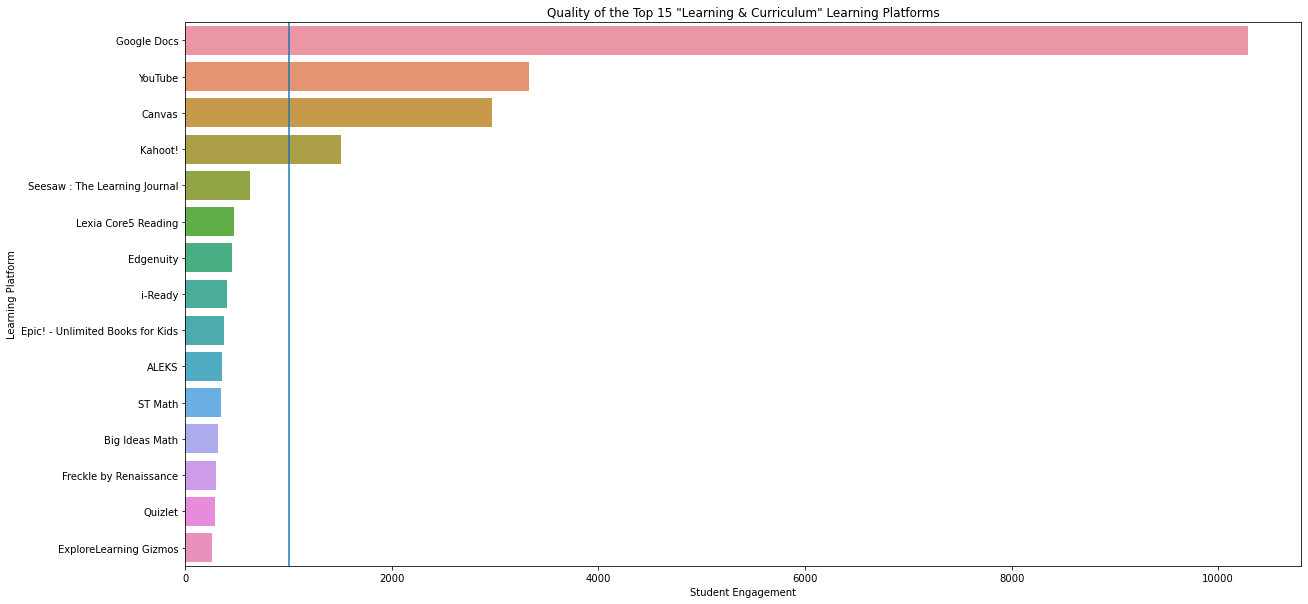

In [65]:
plt.figure(figsize=(20, 10))

sns.barplot(y = 'Product Name', x = 'engagement_index', hue = None, orient = 'h',
    data = primary_essential_func.sort_values(by = 'engagement_index', ascending = False).head(15))

# plt.xticks(rotation = 45)
plt.axvline(x = 1000)

plt.title('Quality of the Top 15 "Learning & Curriculum" Learning Platforms')
plt.xlabel('Student Engagement')
plt.ylabel('Learning Platform')

plt.show()

Now, we'd like to see which Primary Essential 'Sub-Function' in the 'LC Function' has the best learning platforms.

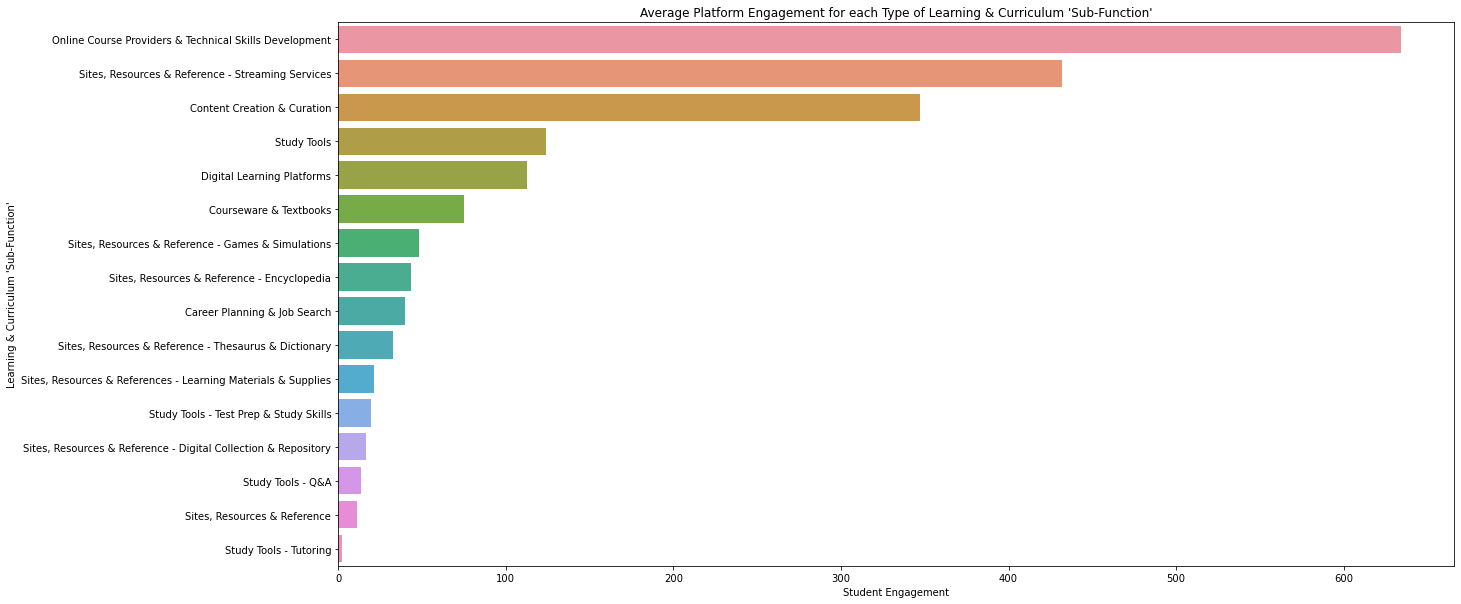

In [66]:
plt.figure(figsize=(20, 10))

primary_essential_func["Primary Essential Function"] = primary_essential_func["Primary Essential Function"].str.replace("LC - ", "")

temp = primary_essential_func[['engagement_index', 'Primary Essential Function']].groupby(['Primary Essential Function']).mean(
    'engagement_index').reset_index().sort_values(by = 'engagement_index', ascending = False)

sns.barplot(y = 'Primary Essential Function', x = 'engagement_index', hue = None, orient = 'h', data = temp)

del temp

plt.title('Average Platform Engagement for each Type of Learning & Curriculum \'Sub-Function\'')
plt.xlabel('Student Engagement')
plt.ylabel('Learning & Curriculum \'Sub-Function\'')

plt.show()

From looking at the graph above, I see that online course providers have the most engagement from students. This makes sense, since online courses are the closest thing to in-person courses (except they're online), so it makes sense that they would have the most engagement.

2nd is streaming services - as we saw Youtube drawing high engagement in the earlier plots. This could be that watching videos can feel more exciting than schoolwork, and various content creators on popular platforms like Youtube can create videos with different styles that can engage students with different interests, attention spans, and learning habits. Additionally, students are likely used to using a streaming platform like Youtube, so that may help in engagement.

Interestingly, 'Games and Simulations' do not hold strong student engagement, which is quite surprising given the popularity of non-educational video games. As well, similar to 'Streaming Services', 'Games and Simulations' are predominantly video- & visual-based, yet there's a strong difference in average engagement. This may imply that there are other factors that make streaming services more affective in getting student engagement.

To confirm whether Streaming Services truly do have ...

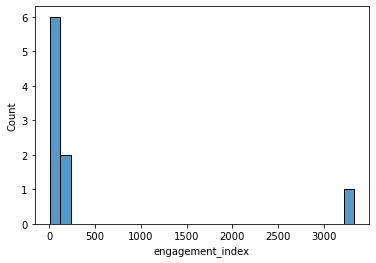

In [67]:
streaming = "Sites, Resources & Reference - Streaming Services"

sns.histplot(data = primary_essential_func[primary_essential_func['Primary Essential Function'] == streaming]['engagement_index'])

plt.show()


In [68]:
gaming_sim = "Sites, Resources & Reference - Games & Simulations"

(data = primary_essential_func[primary_essential_func['Primary Essential Function'] == gaming_sim]['engagement_index'])

plt.show()

SyntaxError: invalid syntax (<ipython-input-68-8572148ea1eb>, line 3)

In [ ]:
engagement_data_grouped

,lp_id,engagement_index
0,10006,0.545
1,10032,0.100
2,10035,0.720
3,10067,0.659
4,10078,3.115
...,...,...
5806,99916,872.793
5807,99922,7.535
5808,99953,1.032
5809,99972,0.050
